# Universidad de Buenos Aires
# IAR - TP FINAL



In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import datetime
import cv2 as cv
import pickle as pkl
import copy

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams["axes.grid"] =True

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Mapa

### Clase Mapa

Contiene todas las utilidades relacionadas a la geolocalización y a la transformación a plano de imágen

In [2]:
class my_map:
    
    color_map = None
    policy = None
    pos_to_coord = None
    coord_to_pos = None
    
    def __init__(self, path_to_map, path_to_policy=None):
        self.color_map = cv.imread(path_to_map)
        self.color_map = cv.cvtColor(self.color_map, cv.COLOR_BGR2RGB)
        if path_to_policy is None:
            self.policy = np.ones(shape=self.map.shape())*255
        else:
            self.policy = cv.imread(path_to_policy,cv.IMREAD_GRAYSCALE)
        
        pass
    
    
    def calibrate(self, calib_coord, calib_bmp):
        self.coord_to_pos = LinearRegression()
        self.coord_to_pos.fit(calib_coord,calib_bmp)
        self.pos_to_coord = LinearRegression()
        self.pos_to_coord.fit(calib_bmp,calib_coord)
    
    
    def to_coord(self, bmp_pos):
        if self.pos_to_coord is not None:
            return self.pos_to_coord.predict(bmp_pos)
        else:
            return None
    
    
    def to_pos(self, coord):
        if self.coord_to_pos is not None:
            return np.round(self.coord_to_pos.predict(coord)).astype(int)
        else:
            return None
    
    
    def plot(self, coord, file=None):
        pos = self.to_pos(coord)
        fig = plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(self.color_map)
        if pos is not None:
            for point in pos:
                plt.scatter(point[1], point[0], c='red', s=15)
        plt.show()
        if file is not None:
            fig.savefig(file, bbox_inches='tight')
        
    
    def plot_policy(self):
        plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(self.policy)
        plt.show()
        
    
    def get_policy_prob (self,coords):
        points = self.to_pos(coords)
        prob = np.zeros(points.shape[0])
        for i,point in enumerate(points):
            if ((point[0]<0) or (point[0]>=self.policy.shape[0]) or (point[1]<0) or (point[1]>=self.policy.shape[1])):
                prob[i] = self.policy[0,0] * 0
            else:
                prob[i] = self.policy[point[0],point[1]] / 255
        
        return prob
    
    @staticmethod
    def destinationPoint(lat, lon, distance, bearing):
        '''
        Returns the destination point from a given point, having travelled the given distance
        on the given initial bearing.

        @param   {number} lat - initial latitude in decimal degrees (eg. 50.123)
        @param   {number} lon - initial longitude in decimal degrees (e.g. -4.321)
        @param   {number} distance - Distance travelled (metres).
        @param   {number} bearing - Initial bearing (in degrees from north).
        @returns {array} destination point as [latitude,longitude] (e.g. [50.123, -4.321])

        @example
        var p = destinationPoint(51.4778, -0.0015, 7794, 300.7); // 51.5135°N, 000.0983°W
        '''
        radius = 6371e3; # (Mean) radius of earth
        
        def toRadians(v):
            return v * math.pi / 180
        
        def toDegrees(v):
            return v * 180 / math.pi


        delta = distance / radius; # angular distance in radians
        theta = toRadians(bearing);

        phi_1 = toRadians(lat);
        lambda_1 = toRadians(lon);
        
        sin_phi_1 = math.sin(phi_1) 
        cos_phi_1 = math.cos(phi_1)
        sin_delta = math.sin(delta)
        cos_delta = math.cos(delta)
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)

        sin_phi_2 = sin_phi_1* cos_delta + cos_phi_1 * sin_delta * cos_theta
        phi_2 = math.asin(sin_phi_2)
        y = sin_theta * sin_delta * cos_phi_1
        x = cos_delta - sin_phi_1 * sin_phi_2
        lambda_2 = lambda_1 + math.atan2(y, x)
        
        lat2 = toDegrees(phi_2)
        
        lon2 = (toDegrees(lambda_2) + 540) % 360 - 180 # normalise to −180..+180°

        return lat2,lon2
    
    @staticmethod
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance in meters between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1 = math.radians (lon1)
        lat1 = math.radians (lat1)
        lon2 =  math.radians (lon2)
        lat2 =  math.radians (lat2)

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a)) 
        r = 6371 * 1000 # Radius of earth in meters.
        return c * r 

### Carga de imagen y mascara de calles

In [3]:
rosario_map_path = 'map/raw.png'
rosario_policy_path = 'map/Rosario_compress_blur.bmp'

work_map = my_map(rosario_map_path,rosario_policy_path)

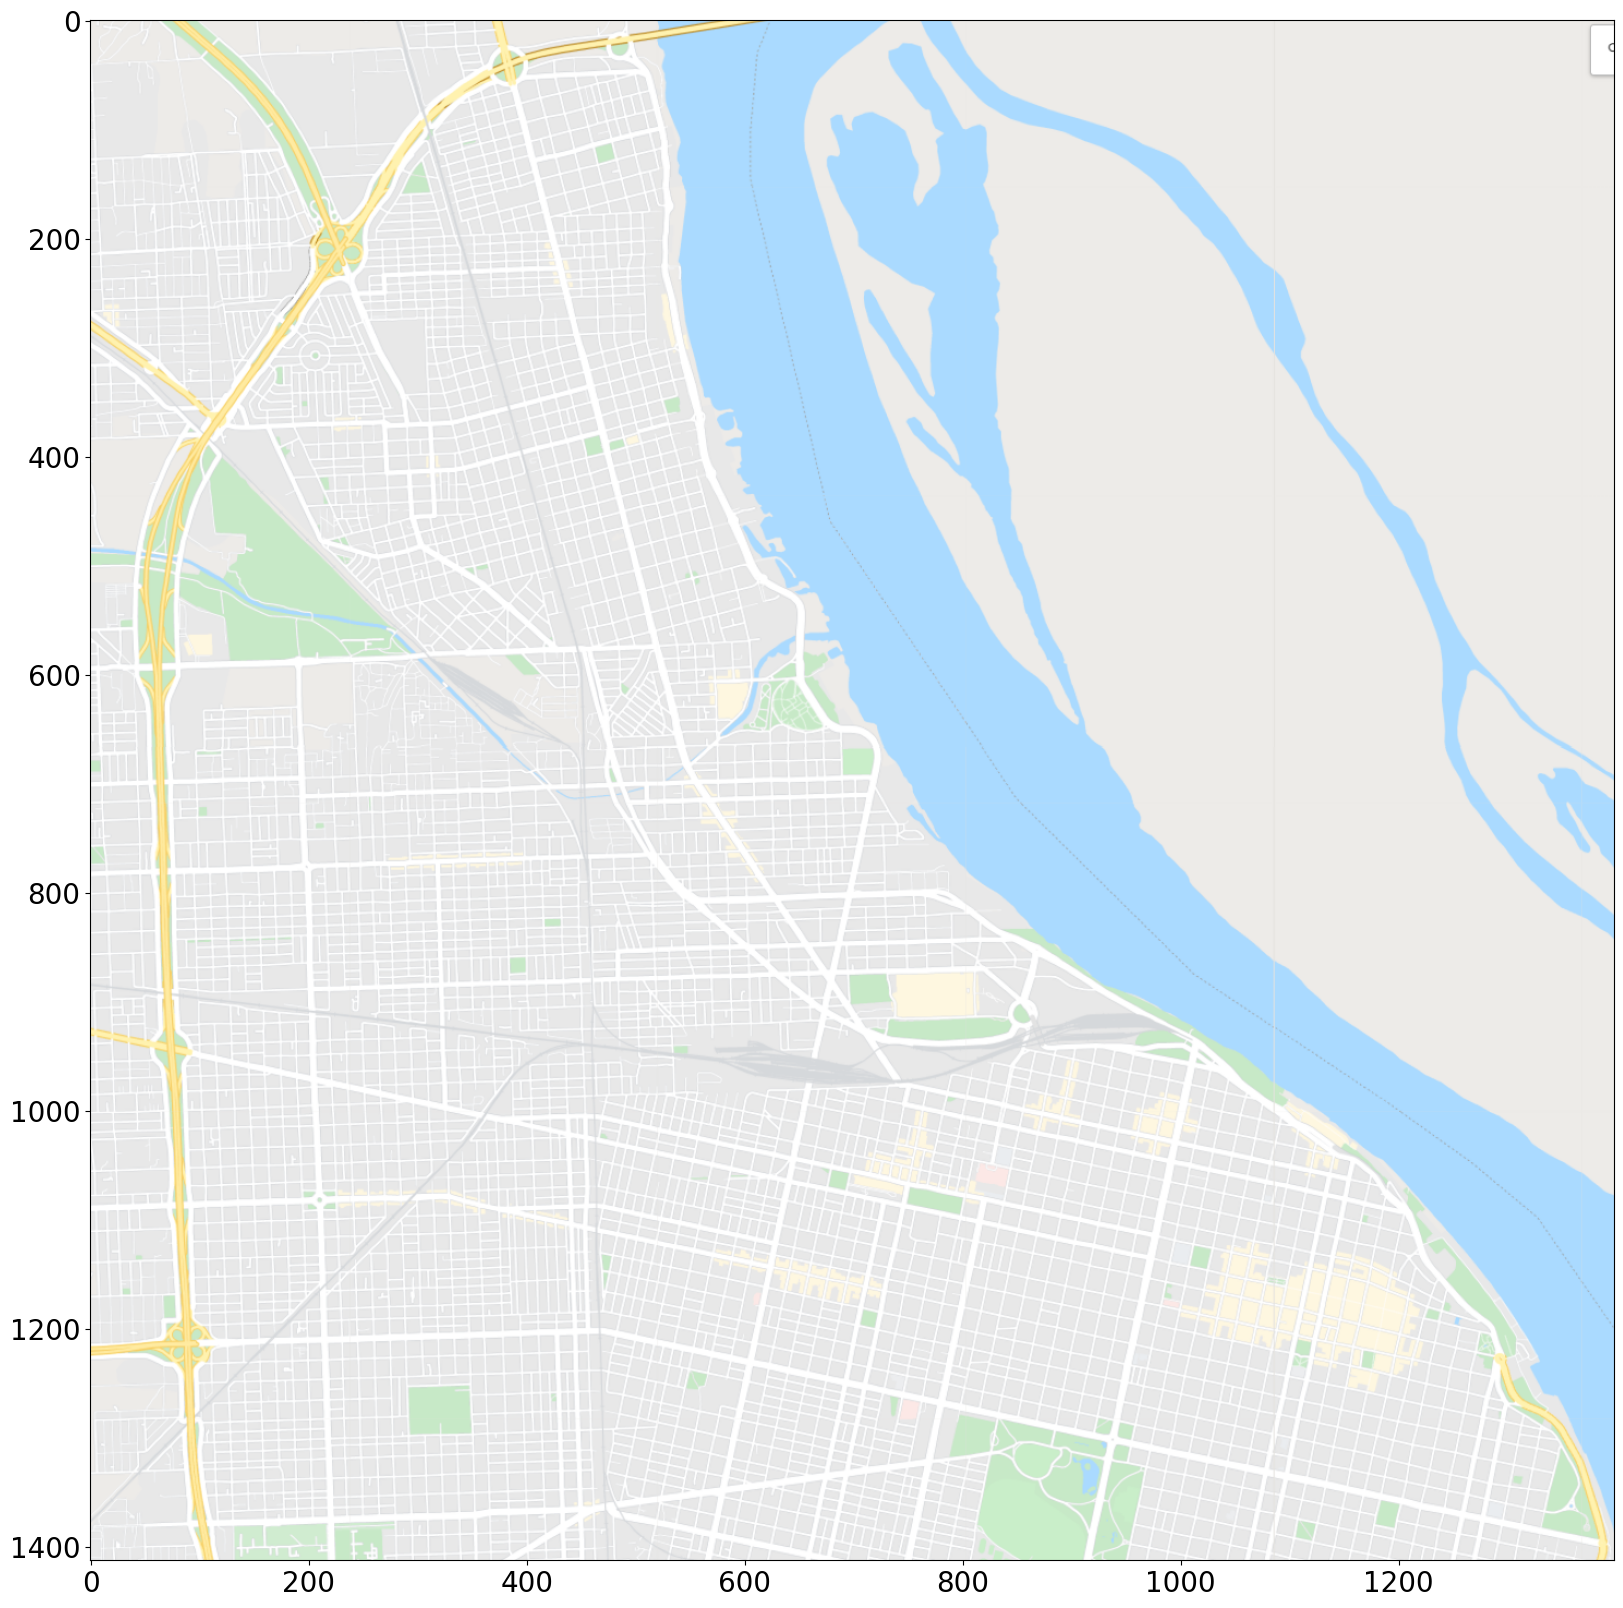

In [4]:
work_map.plot(None)

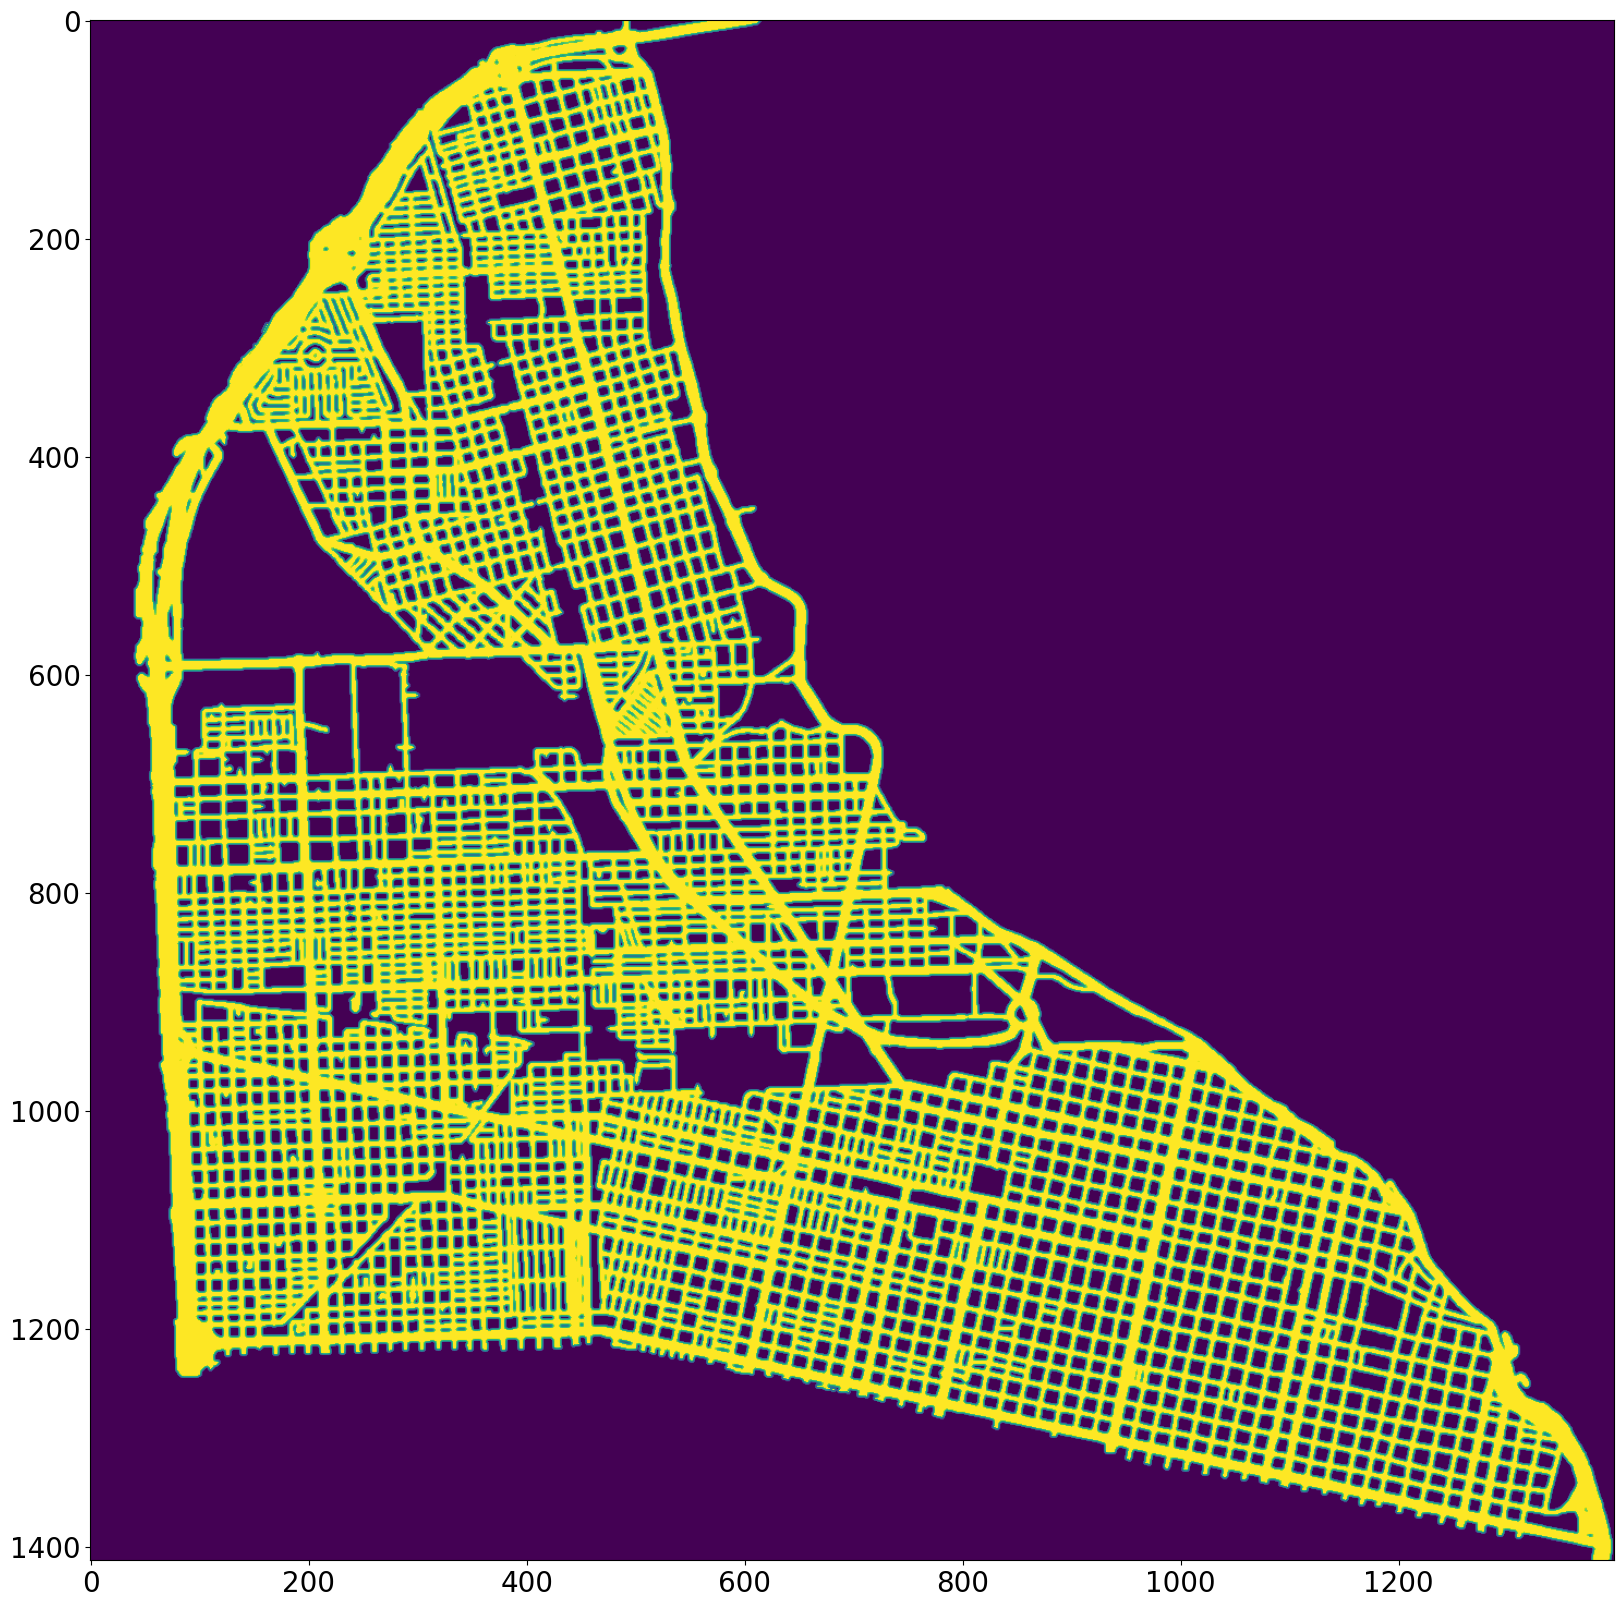

In [5]:
work_map.plot_policy()

## Calibracion

In [6]:
# Puntos de calibración Mapa - BMP
# 1: Alem y Pellegrini
# 2: Pellegrini y Provincias unidas
# 3: Rondeau y Pintor Musto
# 4: Francia y Luis Candido Carballo

calib_coord = [ #[ Latitude , Longitude ]
                [ -32.95907 , -60.63112],
                [ -32.9486 , -60.71226],
                [ -32.87341 , -60.69889],
                [ -32.92526 , -60.66143]
              ]

calib_bmp = [   #[height, width]
                [ 1370 , 1258],
                [ 1212 , 215],
                [ 56, 386],
                [ 853, 867]
            ]

In [7]:
work_map.calibrate(calib_coord,calib_bmp)

In [8]:
# Test con datos de entrenamiento
print(work_map.to_pos([[ -32.87341 , -60.69889]]))
print(work_map.to_coord([[56,386]]))

[[ 56 386]]
[[-32.87338416 -60.69886842]]


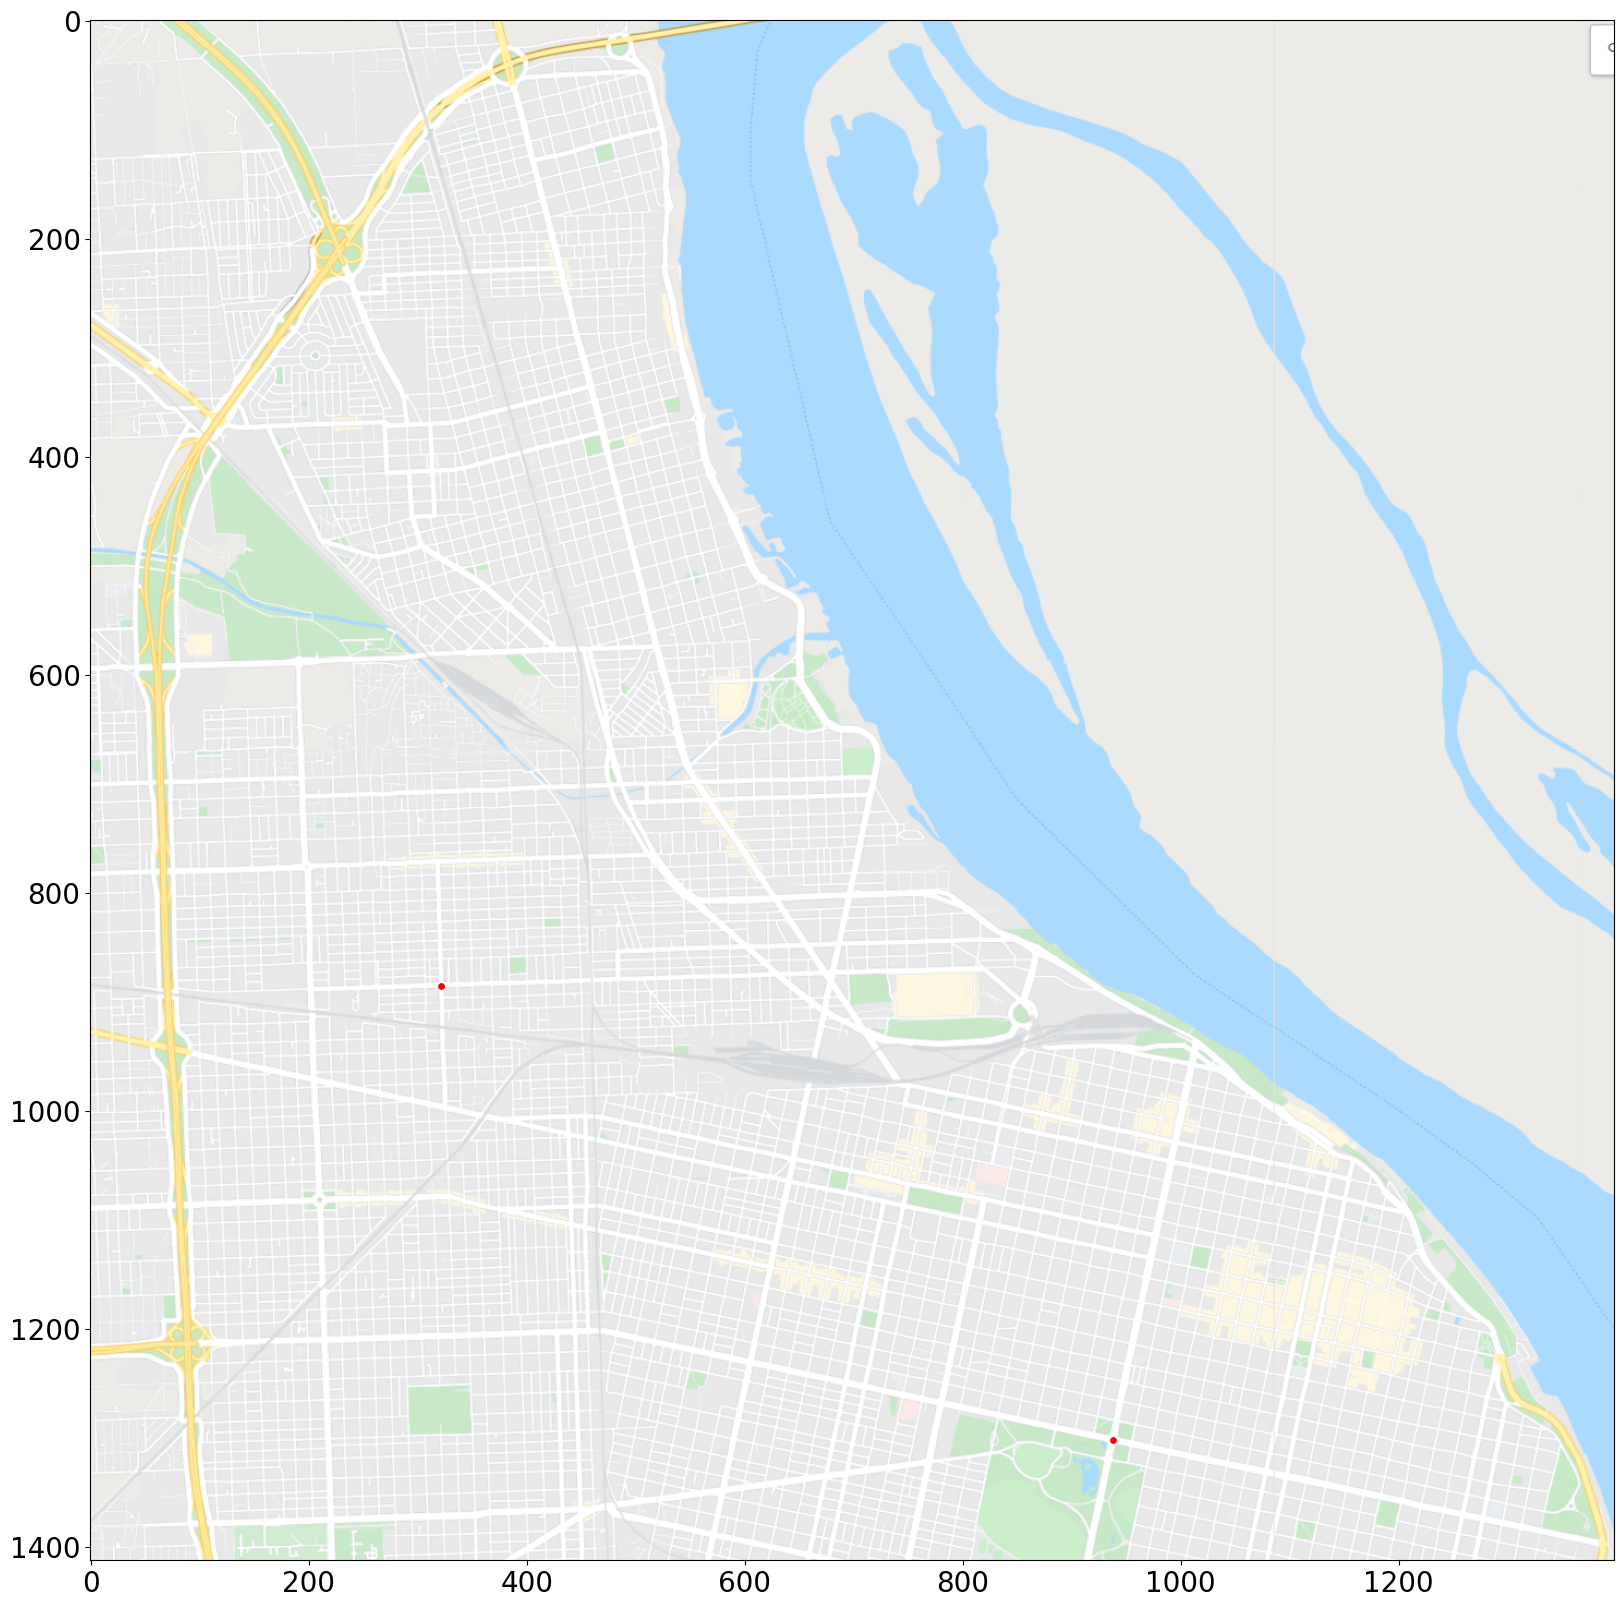

In [9]:
# Test con nuevos datos
# 1: Oroño y Pellegrini
# 2: Solis y Junin
work_map.plot([[ -32.95459 , -60.65599], [ -32.92738 , -60.70398]])

## Dataset de ruta

### Carga y preprocesamiento

Cargamos el dataset de la ruta trazada y lo inspeccionamos

In [10]:
route_2_path = "data/processed/SensorTracker_20211011_185044.csv"
route_2 = pd.read_csv(route_2_path, sep=";")

In [11]:
route_2.head()

Timestamp  Accel_x  Accel_y  Accel_z  Gyro_x  Gyro_y  Gyro_z  \
0  20211011_185044.0   -0.547   -1.083    9.552  -0.000  -0.004   0.004   
1  20211011_185045.0   -0.109   -0.788    9.135   0.004   0.004   0.022   
2  20211011_185045.5   -0.236   -0.829    9.698  -0.001  -0.003   0.015   
3  20211011_185046.0   -0.423   -0.851    9.813  -0.011  -0.010  -0.007   
4  20211011_185046.5   -0.348   -0.764    9.355  -0.010   0.002  -0.006   

   Light  Magnetic_x  Magnetic_y  Magnetic_z  Proximity  Latitude  Longitude  \
0  220.3     -31.931       5.044     -61.669        5.0 -32.87768  -60.69758   
1  220.3     -32.700       6.638     -61.950        5.0 -32.87785  -60.69752   
2  197.4     -32.381       5.531     -61.650        5.0 -32.87790  -60.69750   
3  176.7     -32.663       5.531     -62.419        5.0 -32.87790  -60.69750   
4  176.7     -33.281       6.806     -60.244        5.0 -32.87783  -60.69756   

   Elevation  Speed  
0       41.1   13.7  
1       40.7   17.2  
2       40.7   17.2  
3       40.7   17.2  
4       40.7    6.7

El dataset necesita tratamiento previo:

- Corregir el datetime con milisegundos a un formato correcto de timestamp.
- Convertir velocidad de km/h a m/s
- Dado que algunos sensores se actualizan realmente a 1 segundo en lugar de 500 ms, resampleamos a 1 segundo.

In [12]:
# Correct timestamp
route_2['Timestamp'] = route_2['Timestamp'].map(lambda x: datetime.datetime.\
                                                            strptime(x, "%Y%m%d_%H%M%S.%f").timestamp(), \
                                                na_action='ignore')
# Speed to m/s
route_2['Speed'] = route_2['Speed'].map(lambda x: x/3.6)

# Rename column
route_2['Acceleration'] = route_2['Accel_y']

# Resample to 1s
route_2 = route_2.loc[route_2['Timestamp']%1==0]

# Reset Index
route_2 = route_2.reset_index()

En el dataset falta el angulo de movimiento respecto al norte. Este valor se debería poder obtener a partir del acelerómetro, giróscopo y sensor magnético, pero requieren de una calibración previa. Dado que esta calibración no fue realizada, que los sensores del celular utilizado son de baja calidad y que la fórmula es compleja, se decidió obtener el ángulo de rumbo en forma artificial con los datos del GPS.

En forma similar, para la velocidad se utilizó el sensor de GPS.

In [13]:
def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)

    return brng

In [14]:
route_2['Bearing'] = route_2['Timestamp'].map(lambda x:0)

for i in range(route_2.shape[0]-1):
    route_2['Bearing'].iloc[i] = get_bearing( route_2['Latitude'].iloc[i],
                                             route_2['Longitude'].iloc[i],
                                             route_2['Latitude'].iloc[i+1],
                                             route_2['Longitude'].iloc[i+1]
                                           )
route_2['Bearing'].iloc[-1] =  route_2['Bearing'].iloc[-2]

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
route_2.head()

index     Timestamp  Accel_x  Accel_y  Accel_z  Gyro_x  Gyro_y  Gyro_z  \
0      0  1.633989e+09   -0.547   -1.083    9.552  -0.000  -0.004   0.004   
1      1  1.633989e+09   -0.109   -0.788    9.135   0.004   0.004   0.022   
2      3  1.633989e+09   -0.423   -0.851    9.813  -0.011  -0.010  -0.007   
3      5  1.633989e+09   -0.389   -0.855    9.698  -0.002  -0.009   0.004   
4      7  1.633989e+09   -0.430   -0.846   10.004   0.002  -0.027  -0.004   

   Light  Magnetic_x  Magnetic_y  Magnetic_z  Proximity  Latitude  Longitude  \
0  220.3     -31.931       5.044     -61.669        5.0 -32.87768  -60.69758   
1  220.3     -32.700       6.638     -61.950        5.0 -32.87785  -60.69752   
2  176.7     -32.663       5.531     -62.419        5.0 -32.87790  -60.69750   
3  176.7     -35.400       6.056     -60.188        5.0 -32.87783  -60.69756   
4  176.7     -33.994       6.506     -60.994        5.0 -32.87785  -60.69755   

   Elevation     Speed  Acceleration     Bearing  
0       41.1  3.805556        -1.083  163.489624  
1       40.7  4.777778        -0.788  161.431167  
2       40.7  4.777778        -0.851  -35.748393  
3       40.7  1.861111        -0.855  157.221740  
4       40.3  1.611111        -0.846    0.000000

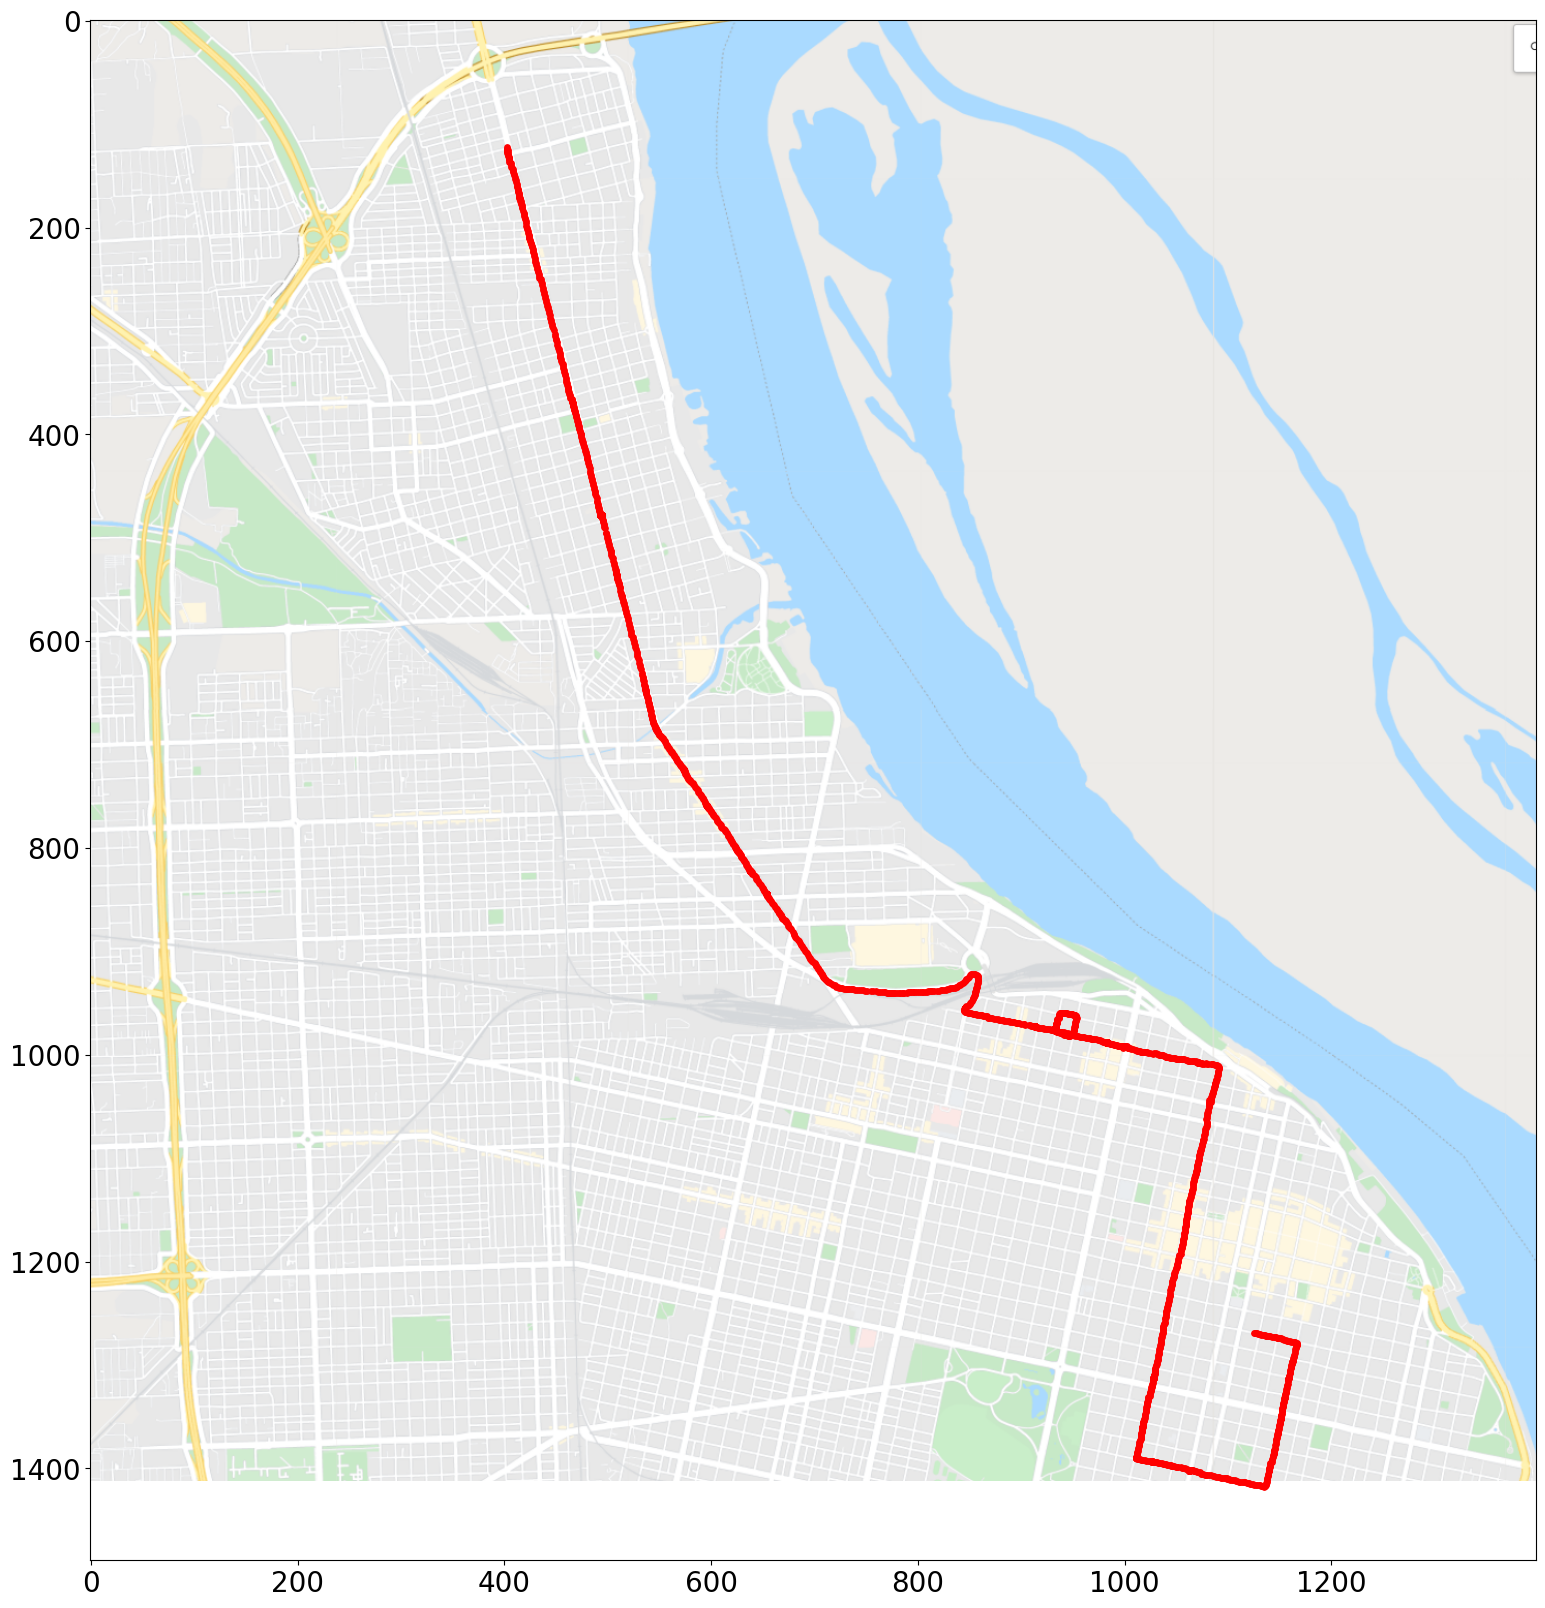

In [16]:
work_map.plot(np.array(route_2[['Latitude','Longitude']]))

## Modelo movimiento

### Clase auto

Contiene todas las funciones para crear el objeto vehículo, generar el movimiento y realizar correcciones en función de las mediciones tomadas.

In [18]:
class my_car():
    
    def __init__(self):
        self.lat = 0.0
        self.lon = 0.0
        self.movement_noise = 0
        self.speed_noise = 0
        self.acceleration_noise = 0
        self.bearing_noise = 0
        
        self.x = np.array([[0.], [0.], [0.], [0.], [0.]]) # estado inicial (distancia, velocidad, aceleracion, bearing, tasa cambio bearing)
        
        self.P = np.array([[10., 0., 0., 0., 0.],
                          [0., 5., 0., 0., 0.],
                          [0., 0., 1., 0., 0.],
                          [0., 0., 0., 10., 0.],
                          [0., 0., 0., 0., 1.]]) # Incertidumbre inicial
        
        self.F = np.array([[1., 1., 0., 0., 0.],
                      [0., 1., 0., 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., 1.],
                      [0., 0., 0., 0., 1.]]) # matriz de estados
        
        self.H = np.array([[0., 1., 0., 0., 0.],
                     [0., 0., 1., 0., 0.],
                     [0., 0., 0., 1., 0.]]) # matriz de mediciones
        
        self.R = np.array([[1., 0., 0.],
                          [0, 0.04, 0.],
                          [ 0., 0., 5.]]) # incertidumbre en la medición
        
           
        
    def set_values(self, new_lat, new_lon, new_speed, new_acceleration, new_bearing):
        self.lat = float(new_lat)
        self.lon = float(new_lon)
        self.position_noise(self.movement_noise)
        self.speed = np.random.normal(new_speed, self.speed_noise, 1)
        self.acceleration = np.random.normal(new_acceleration, self.acceleration_noise, 1)
        self.bearing = np.random.normal(new_bearing, self.bearing_noise, 1)
        
    
    def set_noise(self, new_movement_noise, new_speed_noise, new_acceleration_noise, new_bearing_noise):
        self.movement_noise = float(new_movement_noise)
        self.speed_noise = float(new_speed_noise)
        self.acceleration_noise = float(new_acceleration_noise)
        self.bearing_noise = float(new_bearing_noise)
        #self.R = np.array([[0., self.speed_noise**2, 0., 0., 0.],
        #                  [0., 0., acceleration_noise**2, 0., 0.],
        #                  [0., 0., 0., self.bearing_noise**2, 0.]]) # incertidumbre en la medición
        
    def position_noise(self,meters):
        dist=np.random.random()*meters
        angle=np.random.random()*360-180
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, dist, angle)
        
    
    def move(self, measurement, timestep):
        '''self.F = np.array([[1., timestep, 0, 0., 0.],
                      [0., 1., 0, 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., timestep],
                      [0., 0., 0., 0., 1.]]) # matriz de estados
        # prediction
        self.prev_d = self.x[0]
        self.x = (self.F @ self.x)
        self.P = (self.F @ self.P) @ self.F.T
         measurement update
        y = measurement - (self.H @ self.x)
        S = ((self.H @ self.P) @ self.H.T)+ self.R
        K = (self.P @ self.H.T) @ np.linalg.inv(S)
         estimation
        self.x = self.x + (K @ y)
        self.P = (np.identity(5) - (K @ self.H)) @ self.P '''
        # Apply Noise to the measurement
        measurement[0] = np.random.normal(measurement[0], self.speed_noise, 1)
        measurement[1] = np.random.normal(measurement[1], self.acceleration_noise, 1)
        measurement[2] = np.random.normal(measurement[2], self.bearing_noise, 1)
        
        # Make Movement
        self.x[0] = self.x[1]  * timestep #+ self.x[2] * timestep**2 / 2
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, self.x[0], self.x[3])
        
        # Apply noise to the movement
        self.position_noise(self.movement_noise)
        
        # Update state variables with measurements
        self.x[3] = measurement[2]
        self.x[2] = measurement[1]
        self.x[1] = measurement[0]

## Modelo de partículas

Este modelo creará vehículos por todos los lugares posibles y luego aplicará el modelo de partículas para refinar las posiciones posibles según velocidades y movimientos.

In [25]:
class Horus():
    
    
    def __init__(self, work_map, initial_values, path_to_initial_particles=None):
        self.J = 10000
        self.particles_number = []
        self.center_lat = []
        self.center_lon = []
        self.radius_estimate = []
        self.last_time = 0
        self.work_map = work_map
        
        self.last_time = initial_values['Timestamp']
        
        if path_to_initial_particles is not None:
            self.load_particles(path_to_initial_particles)
        else:
            self.particles=[]
            for i in range(work_map.policy.shape[0]):
                for j in range(work_map.policy.shape[1]):
                    coord = work_map.to_coord([[i,j]])
                    if(work_map.get_policy_prob((coord))>0.5):
                        ford_fiesta = my_car()
                        ford_fiesta.set_noise(0,0,0,0)
                        ford_fiesta.set_values(coord[0][0], 
                                               coord[0][1],
                                               initial_values['Speed'],
                                               initial_values['Acceleration'],
                                               initial_values['Bearing'])
                        self.particles.append(ford_fiesta)
                        
                        
    def save_particles(self, path):
        with open(path, 'wb') as fp:
            pkl.dump(self.particles, fp)
            
            
    def load_particles(self, path):
        with open(path, 'rb') as fp:
            self.particles = pkl.load(fp)
            
            
    def run(self, measurements, path_save=None, step_save=None):
        for step,measurement in measurements.iterrows():
            sensors_measurement = np.array([[measurement['Speed']], [measurement['Acceleration']], [measurement['Bearing']]])
            timestep = measurement['Timestamp'] - self.last_time
            self.last_time = measurement['Timestamp']

            wt = np.zeros(len(self.particles))
    
            for i in range(len(self.particles)):
                self.particles[i].move(sensors_measurement,timestep)
                coord = [[self.particles[i].lat, self.particles[i].lon]]
                wt[i] =self.work_map.get_policy_prob(coord)[0]     
        
            new_particles = [self.particles[idx[0]] for idx in np.argwhere(wt>0)]
            self.particles = new_particles
            wt = wt[wt>0]
            
            self.particles_number.append(len(self.particles))
                
            #Append center and radius
            temp_center_lat=0
            temp_center_lon=0
            for i in range(len(self.particles)):
                temp_center_lat += (self.particles[i].lat/len(self.particles))
                temp_center_lon += (self.particles[i].lon/len(self.particles))
            self.center_lat.append(temp_center_lat)
            self.center_lon.append(temp_center_lon)

            max_temp_radius = 0
            for i in range(len(self.particles)):
                temp_radius=my_map.haversine(temp_center_lat,temp_center_lon,self.particles[i].lat,self.particles[i].lon)
                max_tem_radius = max(max_temp_radius, temp_radius)
            self.radius_estimate.append(max_tem_radius)
                
            if path_save is not None:
                if ((step%step_save) == 0):
                    self.save_particles(path_save+'particles_'+str(step)+'.pkl')

            if(round(np.sum(wt))<self.J):
                self.particles = Horus.resampling_wheel(self.particles,wt, self.J)
                self.particles_number.append(len(self.particles))
            
            
    def plot(self, points=10000, save_path=None):
        points = min(points,len(self.particles))
        idx = np.random.randint(0, len(self.particles), points)
        if save_path is not None:
            self.work_map.plot(np.array([[self.particles[i].lat,self.particles[i].lon] for i in idx]), save_path)
        else:
            self.work_map.plot(np.array([[self.particles[i].lat,self.particles[i].lon] for i in idx]))
        
        
        
    @staticmethod
    def resampling_wheel(list_particles, weights, J):
        new_list_particles = []
        wheel = np.cumsum(weights) / np.sum(weights)
        for i in range(J):
            rand_value = np.random.random()
            index = np.argmax(wheel>rand_value)
            new_list_particles.append(copy.deepcopy(list_particles[index]))
            new_list_particles[-1].position_noise(10)
        return new_list_particles
    
    
    

In [26]:
particle_model = Horus(work_map, route_2.iloc[0], 'route2_outputs/particles_saves/init_particles.pkl') #Load initial particles
#particle_model = Horus(work_map, route_2.iloc[0]) #create initial particles
#particle_model.save_particles('route2_outputs/particles_saves/init_particles.pkl')

In [27]:
particle_model.run(route_2[1:], path_save='route2_outputs/particles_saves/', step_save=20)

In [28]:
with open('route2_outputs/horus_saves/horus_1.pkl', 'wb') as fp:
    pkl.dump(particle_model, fp)

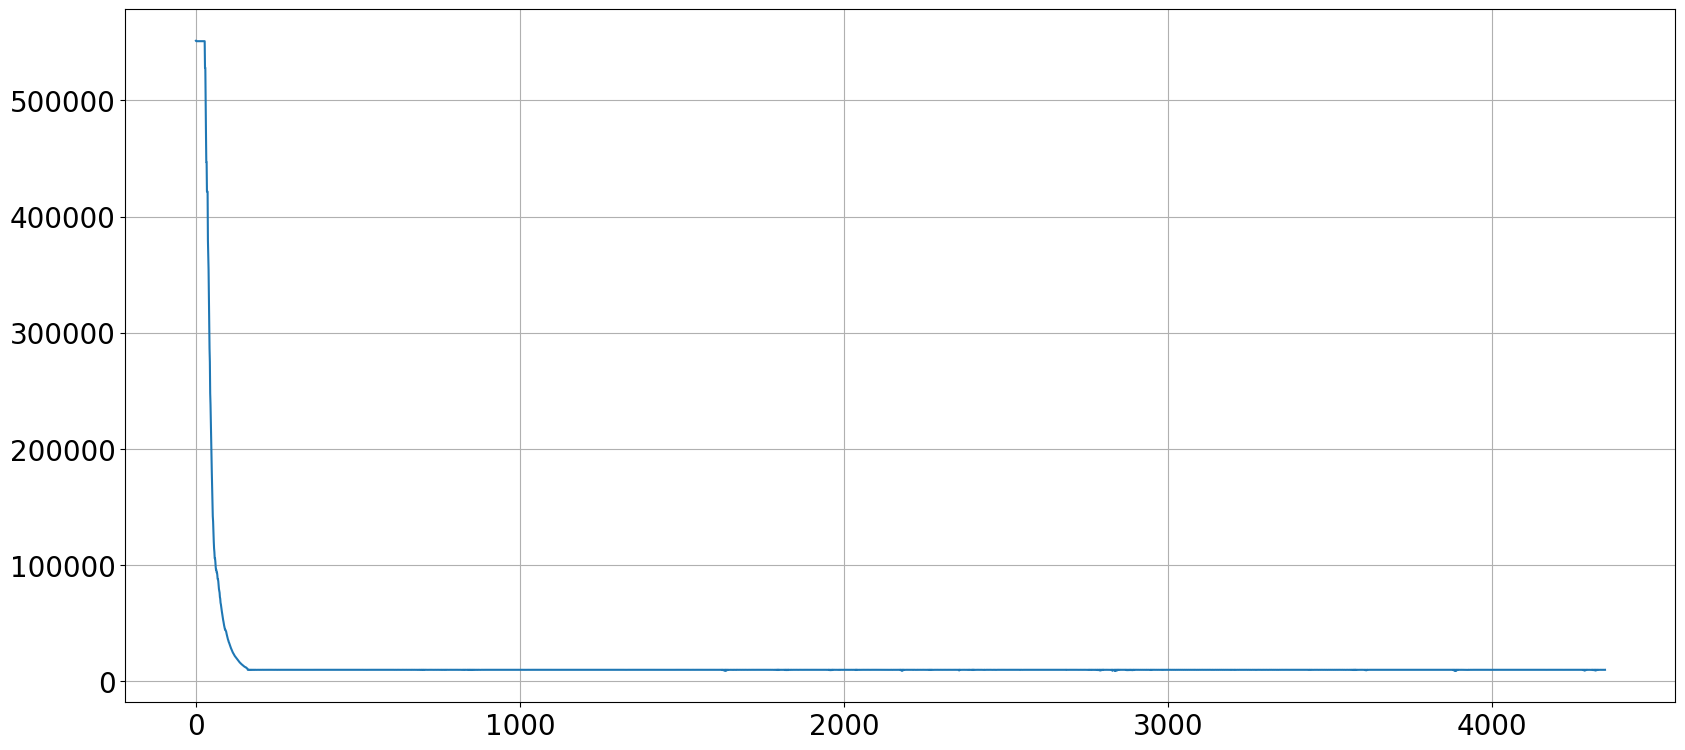

In [29]:
plt.figure()
plt.plot(particle_model.particles_number)
plt.show()

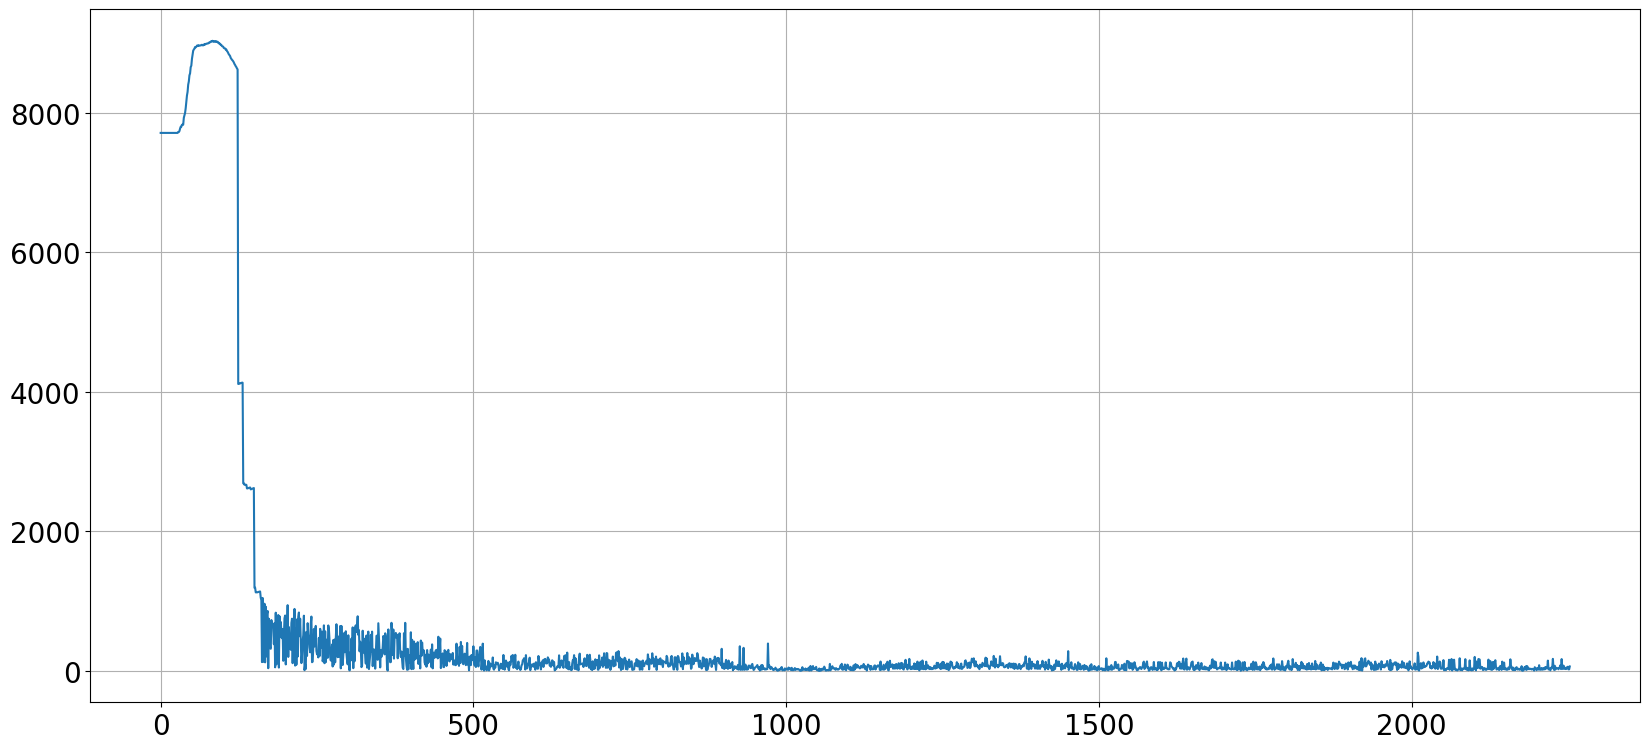

In [30]:
plt.figure()
plt.plot(particle_model.radius_estimate)
plt.show()